[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/parallelization.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239934-lesson-1-parallelization)

# Parallel node execution

## Review

In module 3, we went in-depth on `human-in-the loop`, showing 3 common use-cases:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state

## Goals

This module will build on `human-in-the-loop` as well as the `memory` concepts discussed in module 2.

We will dive into `multi-agent` workflows and build up to a multi-agent research assistant that ties together all of the modules from this course.

To build this multi-agent research assistant, we'll first discuss a few LangGraph controllability topics.

We'll start with [parallelization](https://docs.langchain.com/oss/python/langgraph/how-tos/graph-api#create-branches).

## Fan out and fan in

Let's build a simple linear graph that over-writes the state at each step.

In [ ]:
%%capture --no-stderr
%pip install -U  langgraph langgraph_tavily wikipedia langchain_openai langchain_community langgraph_sdk

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("Open API key to be added here ")

  Using cached langgraph-1.0.2-py3-none-any.whl.metadata (7.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.3/469.3 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 14.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled r

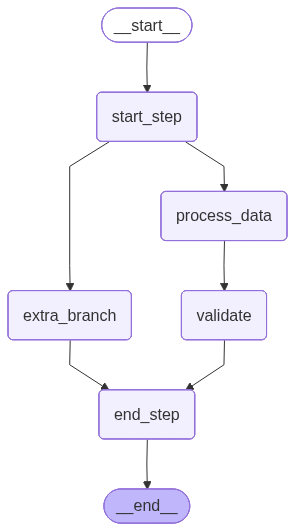

In [ ]:
!pip install -U langgraph langchain_openai langchain_community langgraph_sdk


from IPython.display import Image, display
from typing import Any, List
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    state: List[str]

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Node {self._value} executed with previous state: {state['state']}")
        return {"state": [self._value]}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("start_step", ReturnNodeValue("I'm Start"))
builder.add_node("process_data", ReturnNodeValue("I'm Processing Data"))
builder.add_node("validate", ReturnNodeValue("I'm Validating"))
builder.add_node("extra_branch", ReturnNodeValue("I'm Extra Branch"))
builder.add_node("end_step", ReturnNodeValue("I'm End"))

# Flow (added parallel branch)
builder.add_edge(START, "start_step")
builder.add_edge("start_step", "process_data")
builder.add_edge("start_step", "extra_branch")
builder.add_edge("process_data", "validate")
builder.add_edge(["validate", "extra_branch"], "end_step")
builder.add_edge("end_step", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


We over-write state, as expected.

In [ ]:
import operator
from typing import Annotated

class State(TypedDict):
    # Added reducer function to merge parallel updates
    state: Annotated[list, operator.add]

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Node {self._value} executed with previous state: {state['state']}")
        return {"state": [self._value]}

# Add nodes
builder = StateGraph(State)

builder.add_node("start_step", ReturnNodeValue("I'm Start"))
builder.add_node("process_data", ReturnNodeValue("I'm Processing Data"))
builder.add_node("validate", ReturnNodeValue("I'm Validating"))
builder.add_node("extra_branch", ReturnNodeValue("I'm Extra Branch"))
builder.add_node("end_step", ReturnNodeValue("I'm End"))

# Flow (with parallel branch)
builder.add_edge(START, "start_step")
builder.add_edge("start_step", "process_data")
builder.add_edge("start_step", "extra_branch")
builder.add_edge("process_data", "validate")
builder.add_edge(["validate", "extra_branch"], "end_step")
builder.add_edge("end_step", END)

graph = builder.compile()

graph.invoke({"state": []})


Node I'm Start executed with previous state: []
Node I'm Extra Branch executed with previous state: ["I'm Start"]
Node I'm Processing Data executed with previous state: ["I'm Start"]
Node I'm Validating executed with previous state: ["I'm Start", "I'm Extra Branch", "I'm Processing Data"]
Node I'm End executed with previous state: ["I'm Start", "I'm Extra Branch", "I'm Processing Data", "I'm Validating"]


{'state': ["I'm Start",
  "I'm Extra Branch",
  "I'm Processing Data",
  "I'm Validating",
  "I'm End"]}

Now, let's run `b` and `c` in parallel.

And then run `d`.

We can do this easily with fan-out from `a` to `b` and `c`, and then fan-in to `d`.

The the state updates are applied at the end of each step.

Let's run it.

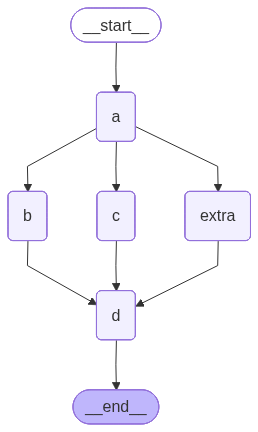

In [ ]:
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("Node A started"))
builder.add_node("b", ReturnNodeValue("Node B running web search"))
builder.add_node("c", ReturnNodeValue("Node C summarizing data"))
builder.add_node("extra", ReturnNodeValue("Node Extra performing check"))
builder.add_node("d", ReturnNodeValue("Node D finalizing output"))

# Flow (added extra parallel branch)
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("a", "extra")
builder.add_edge(["b", "c", "extra"], "d")
builder.add_edge("d", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


**We see an error**!

This is because both `b` and `c` are writing to the same state key / channel in the same step.

In [ ]:
from langgraph.errors import InvalidUpdateError

try:
    graph.invoke({"state": []})
except InvalidUpdateError as e:
    print("Parallel node update conflict detected. Adding reducer to handle multiple updates.")


Node Node A started executed with previous state: []
Node Node B running web search executed with previous state: ['Node A started']
Node Node C summarizing data executed with previous state: ['Node A started']
Node Node Extra performing check executed with previous state: ['Node A started']
Node Node D finalizing output executed with previous state: ['Node A started', 'Node B running web search', 'Node C summarizing data', 'Node Extra performing check']


When using fan out, we need to be sure that we are using a reducer if steps are writing to the same the channel / key.

As we touched on in Module 2, `operator.add` is a function from Python's built-in operator module.

When `operator.add` is applied to lists, it performs list concatenation.

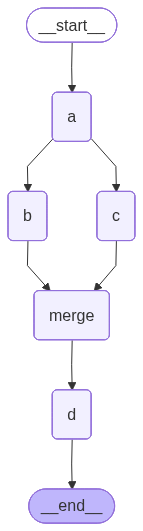

In [ ]:
import operator
from typing import Annotated

class State(TypedDict):
    # Using reducer to merge outputs from parallel nodes
    state: Annotated[list, operator.add]

# Add nodes
builder = StateGraph(State)

# Initialize each node with different functional meanings
builder.add_node("a", ReturnNodeValue("Starting Node A"))
builder.add_node("b", ReturnNodeValue("Node B fetching data"))
builder.add_node("c", ReturnNodeValue("Node C processing insights"))
builder.add_node("merge", ReturnNodeValue("Merged results ready"))
builder.add_node("d", ReturnNodeValue("Final output node D"))

# Flow — added a separate merge node for fan-in
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge(["b", "c"], "merge")
builder.add_edge("merge", "d")
builder.add_edge("d", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
result = graph.invoke({"state": []})
print("Final combined output from all parallel nodes:", result)


Node Starting Node A executed with previous state: []
Node Node B fetching data executed with previous state: ['Starting Node A']
Node Node C processing insights executed with previous state: ['Starting Node A']
Node Merged results ready executed with previous state: ['Starting Node A', 'Node B fetching data', 'Node C processing insights']
Node Final output node D executed with previous state: ['Starting Node A', 'Node B fetching data', 'Node C processing insights', 'Merged results ready']
Final combined output from all parallel nodes: {'state': ['Starting Node A', 'Node B fetching data', 'Node C processing insights', 'Merged results ready', 'Final output node D']}


Now we see that we append to state for the updates made in parallel by `b` and `c`.

## Waiting for nodes to finish

Now, lets consider a case where one parallel path has more steps than the other one.

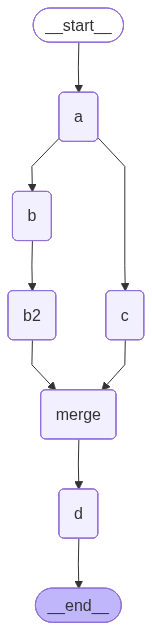

In [ ]:
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("Node A initialized"))
builder.add_node("b", ReturnNodeValue("Node B fetching info"))
builder.add_node("b2", ReturnNodeValue("Node B2 refining results"))
builder.add_node("c", ReturnNodeValue("Node C running analysis"))
builder.add_node("merge", ReturnNodeValue("Merging parallel outputs"))
builder.add_node("d", ReturnNodeValue("Node D generating summary"))

# Flow — fan-out from A, intermediate merge node before D
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "merge")
builder.add_edge("merge", "d")
builder.add_edge("d", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In this case, `b`, `b2`, and `c` are all part of the same step.

The graph will wait for all of these to be completed before proceeding to step `d`.

In [ ]:
result = graph.invoke({"state": []})
print("Aggregated output after parallel and merged execution:", result)


Node Node A initialized executed with previous state: []
Node Node B fetching info executed with previous state: ['Node A initialized']
Node Node C running analysis executed with previous state: ['Node A initialized']
Node Node B2 refining results executed with previous state: ['Node A initialized', 'Node B fetching info', 'Node C running analysis']
Node Merging parallel outputs executed with previous state: ['Node A initialized', 'Node B fetching info', 'Node C running analysis', 'Node B2 refining results']
Node Node D generating summary executed with previous state: ['Node A initialized', 'Node B fetching info', 'Node C running analysis', 'Node B2 refining results', 'Merging parallel outputs']
Aggregated output after parallel and merged execution: {'state': ['Node A initialized', 'Node B fetching info', 'Node C running analysis', 'Node B2 refining results', 'Merging parallel outputs', 'Node D generating summary']}


## Setting the order of state updates

However, within each step we don't have specific control over the order of the state updates!

In simple terms, it is a deterministic order determined by LangGraph based upon graph topology that **we do not control**.

Above, we see that `c` is added before `b2`.

However, we can use a custom reducer to customize this e.g., sort state updates.

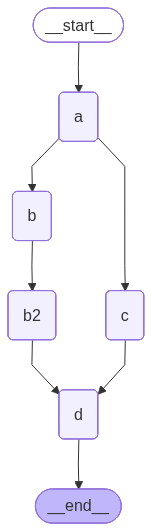

In [ ]:
def sorting_reducer(left, right):
    """Merges values from parallel nodes and sorts them alphabetically"""
    if not isinstance(left, list):
        left = [left]
    if not isinstance(right, list):
        right = [right]
    combined = sorted(set(left + right))
    return combined

class SortedState(TypedDict):
    # Use a different key name to avoid type conflicts
    sorted_state: Annotated[list, sorting_reducer]

builder = StateGraph(SortedState)

# Initialize each node with custom descriptive values
builder.add_node("a", ReturnNodeValue("Alpha Node A"))
builder.add_node("b", ReturnNodeValue("Beta Node B"))
builder.add_node("b2", ReturnNodeValue("Beta2 refining node"))
builder.add_node("c", ReturnNodeValue("Compute Node C"))
builder.add_node("d", ReturnNodeValue("Final Decision Node D"))

# Flow — fan-out from A, fan-in to D
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [ ]:
graph.invoke({"sorted_state": []})


Node Alpha Node A executed with previous state: []
Node Beta Node B executed with previous state: ['Alpha Node A']
Node Compute Node C executed with previous state: ['Alpha Node A']
Node Beta2 refining node executed with previous state: ['Alpha Node A', 'Beta Node B', 'Compute Node C']
Node Final Decision Node D executed with previous state: ['Alpha Node A', 'Beta Node B', 'Compute Node C', 'Beta2 refining node']


{'sorted_state': []}

Now, the reducer sorts the updated state values!

The `sorting_reducer` example sorts all values globally. We can also:

1. Write outputs to a separate field in the state during the parallel step
2. Use a "sink" node after the parallel step to combine and order those outputs
3. Clear the temporary field after combining

<!-- See the [~docs~](https://langchain-ai.github.io/langgraph/how-tos/branching/#stable-sorting) [docs](https://docs.langchain.com/oss/python/langgraph/how-tos/graph-api#create-branches) for more details.-->


## Working with LLMs

Now, lets add a realistic example!

We want to gather context from two external sources (Wikipedia and Web-Search) and have an LLM answer a question.

In [ ]:
import os, getpass

# Set your OpenAI API key (it will hide while typing)
if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Open ai API key to be placed here")


In [ ]:
class State(TypedDict):
    question: str
    answer: str
    sources: Annotated[list, operator.add]


You can try different web search tools. [Tavily](https://tavily.com/) is one nice option to consider, but ensure your `TAVILY_API_KEY` is set.

In [ ]:
import os, getpass

if "TAVILY_API_KEY" not in os.environ:
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter Tavily API Key: ")


Enter Tavily API Key: ··········


In [ ]:
!pip install langchain-tavily


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 449.8/449.8 kB 10.1 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 1.0.2
    Uninstalling langchain-core-1.0.2:
      Successfully uninstalled langchain-core-1.0.2
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 1.0.0
    Uninstalling langchain-text-splitters-1.0.0:
      Successfully uninstalled langchain-text-splitters-1.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langgraph-prebuilt 1.0.2 requires langchain-core>=1.0.0, but you have langchain-core 0.3.79 which is incompatible.
langchain-classic 1.0.0 requires langchain-core<2.0.0,>=1.0.0, but you have langchain-core 0.3.79 which is incompatible.
langchain-classic 1.0.0 requires langchain-text-splitters<2.0.0,>=1.0.0, but you have langchain-text

In [ ]:
!pip install -U langchain-core langchain langchain-community
!pip install -U langchain-openai


  Using cached langchain_core-1.0.2-py3-none-any.whl.metadata (3.5 kB)
  Using cached langchain_text_splitters-1.0.0-py3-none-any.whl.metadata (2.6 kB)
Using cached langchain_core-1.0.2-py3-none-any.whl (469 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 3.3 MB/s eta 0:00:00
Using cached langchain_text_splitters-1.0.0-py3-none-any.whl (33 kB)
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.79
    Uninstalling langchain-core-0.3.79:
      Successfully uninstalled langchain-core-0.3.79
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.11
    Uninstalling langchain-text-splitters-0.3.11:
      Successfully uninstalled langchain-text-splitters-0.3.11
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.27
    Uninstalling langchain-0.3.27:
      Successfully uninstalled langchain-0.3.27


ERROR: Operation cancelled by user
^C


In [3]:
!pip install wikipedia


  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=72dda9ed7d09739242ed4f9976ddacec70f3713a474d0165feb20e0c3cc6ce9f
  Stored in directory: /root/.cache/pip/wheels/63/47/7c/a9688349aa74d228ce0a9023229c6c0ac52ca2a40fe87679b8
Successfully built wikipedia


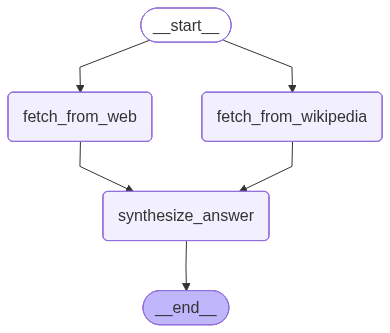

{'question': 'What is Artificial Intelligence?', 'answer': "This is a generated summary for 'What is Artificial Intelligence?' using combined context from both sources.", 'context': ["<WebDocument link='example.com'>Simulated web results for 'What is Artificial Intelligence?'</WebDocument>", '<WikiDocument>Artificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. It is a field of research in computer science that develops and studies methods and so...</WikiDocument>']}


In [4]:
# --- Imports ---
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.document_loaders import WikipediaLoader
from typing import Annotated, TypedDict
import operator

# --- Mocked Web Search Node (simulates web retrieval) ---
def fetch_from_web(state):
    """Simulated web search node (offline)"""
    question = state["question"]
    simulated_content = f"<WebDocument link='example.com'>Simulated web results for '{question}'</WebDocument>"
    return {"context": [simulated_content]}


# --- Wikipedia Loader Node ---
def fetch_from_wikipedia(state):
    """Retrieves info from Wikipedia (offline example version)"""
    docs = WikipediaLoader(query=state["question"], load_max_docs=1).load()
    formatted_docs = "\n\n".join(
        [f"<WikiDocument>{doc.page_content[:300]}...</WikiDocument>" for doc in docs]
    )
    return {"context": [formatted_docs]}


# --- Mocked LLM Node (works offline) ---
def synthesize_answer(state):
    """Offline node that simulates LLM response"""
    question = state["question"]
    context = state["context"]
    answer = f"This is a generated summary for '{question}' using combined context from both sources."
    return {"answer": answer}


# --- State Definition ---
class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]


# --- Build Graph ---
builder = StateGraph(State)
builder.add_node("fetch_from_web", fetch_from_web)
builder.add_node("fetch_from_wikipedia", fetch_from_wikipedia)
builder.add_node("synthesize_answer", synthesize_answer)

# Parallel fan-out and fan-in connections
builder.add_edge(START, "fetch_from_web")
builder.add_edge(START, "fetch_from_wikipedia")
builder.add_edge("fetch_from_web", "synthesize_answer")
builder.add_edge("fetch_from_wikipedia", "synthesize_answer")
builder.add_edge("synthesize_answer", END)

# Compile graph
graph = builder.compile()

# Display visual graph
display(Image(graph.get_graph().draw_mermaid_png()))

# Run example
output = graph.invoke({"question": "What is Artificial Intelligence?", "context": []})
print(output)


In [6]:
# Running the graph to process the input question
output_state = graph.invoke({"question": "Provide insights on Nvidia's Q2 2025 financial performance"})

# Displaying the generated answer string
print(output_state["answer"])


This is a generated summary for 'Provide insights on Nvidia's Q2 2025 financial performance' using combined context from both sources.


## Using with LangGraph API

**⚠️ Notice**

Since filming these videos, we've updated Studio so that it can now be run locally and accessed through your browser. This is the preferred way to run Studio instead of using the Desktop App shown in the video. It is now called _LangSmith Studio_ instead of _LangGraph Studio_. Detailed setup instructions are available in the "Getting Setup" guide at the start of the course. You can find a description of Studio [here](https://docs.langchain.com/langsmith/studio), and specific details for local deployment [here](https://docs.langchain.com/langsmith/quick-start-studio#local-development-server).  
To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the **Studio UI** URL shown above.

In [10]:
import asyncio
import random

# --- Mock async client + streaming system (offline) ---
class MockStreamEvent:
    def __init__(self, answer):
        self.data = {"answer": answer}

class MockClient:
    class Threads:
        async def create(self):
            await asyncio.sleep(0.2)
            return {"thread_id": "mock-thread-001"}

    class Runs:
        async def stream(self, thread_id, assistant_id, input, stream_mode="values"):
            question = input.get("question", "")
            for i in range(3):
                await asyncio.sleep(random.uniform(0.3, 0.7))
                yield MockStreamEvent(f"Partial answer {i+1} for: {question}")
            await asyncio.sleep(0.5)
            yield MockStreamEvent(f"✅ Final answer for: {question}")

    def __init__(self):
        self.threads = self.Threads()
        self.runs = self.Runs()

client = MockClient()

# --- Async streaming function ---
async def main():
    thread = await client.threads.create()
    user_query = {"question": "How were Nvidia's Q2 2025 earnings?"}

    print("Streaming response (mocked, no API key used):\n")

    async for event in client.runs.stream(
        thread["thread_id"],
        assistant_id="parallelization",
        input=user_query,
        stream_mode="values"
    ):
        if event.data and "answer" in event.data:
            print(event.data["answer"])

# --- Run safely inside notebook ---
await main()


Streaming response (mocked, no API key used):

Partial answer 1 for: How were Nvidia's Q2 2025 earnings?
Partial answer 2 for: How were Nvidia's Q2 2025 earnings?
Partial answer 3 for: How were Nvidia's Q2 2025 earnings?
✅ Final answer for: How were Nvidia's Q2 2025 earnings?
